In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
bb1 = [35.588654,35.591812,-78.808848,-78.806101]
bb2 = [35.581702,35.584546,-78.800222,-78.797915]

In [3]:
bb = []
bb.append(bb1)
bb.append(bb2)

In [4]:
bb3 = [35.596373,35.598830,-78.784815,-78.782240]
bb4 = [35.598926,35.600409,-78.784841,-78.782202]

In [5]:
bb.append(bb3)
bb.append(bb4)

In [6]:
bb

[[35.588654, 35.591812, -78.808848, -78.806101],
 [35.581702, 35.584546, -78.800222, -78.797915],
 [35.596373, 35.59883, -78.784815, -78.78224],
 [35.598926, 35.600409, -78.784841, -78.782202]]

In [7]:
nodelist = []
for i in range(4):
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]    
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    nodelist.append(G.nodes)

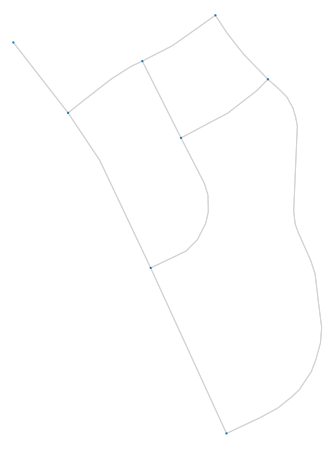

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
east, north, west, south = -78.815266,35.565956,-78.810330,35.571541

#north, south, east, west = 35.588654,35.591812,-78.808848,-78.806101
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

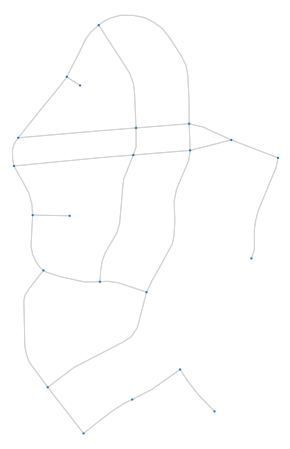

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
east, north, west, south = -78.817635,35.569646,-78.810403,35.576505
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

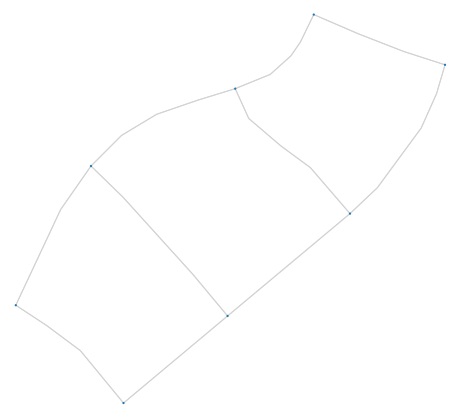

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [20]:
east, north, west, south = -78.810579,35.571185,-78.806234,35.574300
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

In [26]:
finalroutes = []

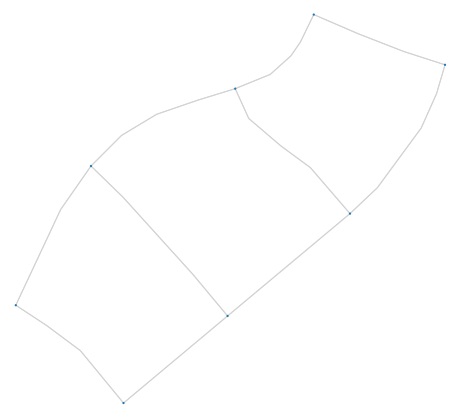

In [39]:

#Creating a bounding box
east, north, west, south = -78.810579,35.571185,-78.806234,35.574300    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)



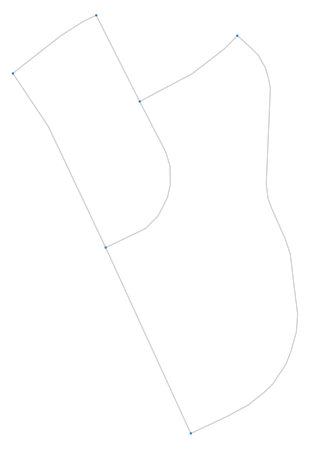

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [32]:
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

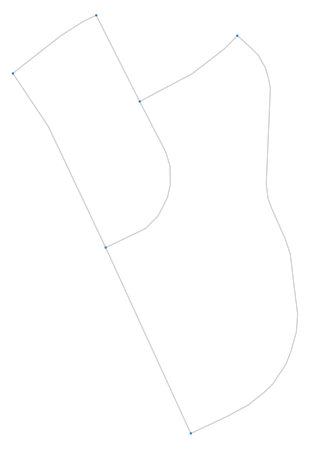

In [38]:

#Creating a bounding box
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)



In [40]:
#NOGO
#Creating a bounding box
east, north, west, south = -78.809811,35.566259,-78.805541,35.569471   
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)



In [41]:
#------------

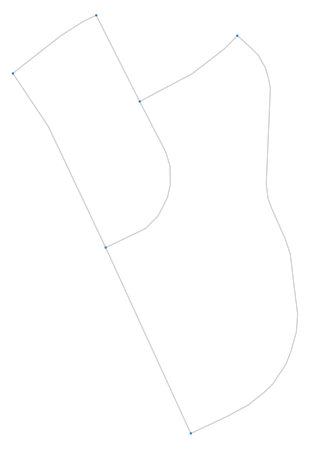

In [42]:

#Creating a bounding box
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

    
    
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)



In [44]:
df3

,level_0,index,Latitude,Longitude,ID
0,0,2.0,35.568139,-78.813101,2.0
1,1,3.0,35.569701,-78.814124,3.0
2,2,4.0,35.570223,-78.813205,4.0
3,3,0.0,35.569449,-78.812725,0.0
4,4,1.0,35.570040,-78.811649,1.0
5,5,5.0,35.566471,-78.812162,5.0
6,0,2.0,35.568139,-78.813101,2.0


In [45]:
a

[2, 3, 4, 0, 1, 5]

In [50]:
data

,Nodes,Latitude,Longitude
0,1278912898,35.569449,-78.812725
1,1278913064,35.570040,-78.811649
2,1278913066,35.568139,-78.813101
3,1278913077,35.569701,-78.814124
4,1278913206,35.570223,-78.813205
5,1278913223,35.566471,-78.812162


In [171]:
df4 = df3

In [172]:
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)

In [173]:
Nodes[a[0]]

1278913066

In [174]:
df4 = pd.concat([df4,dfnodes],axis=1)

In [175]:
df4

,level_0,index,Latitude,Longitude,ID,Nodes
0,0,2.0,35.568139,-78.813101,2.0,1278913066
1,1,3.0,35.569701,-78.814124,3.0,1278913077
2,2,4.0,35.570223,-78.813205,4.0,1278913206
3,3,0.0,35.569449,-78.812725,0.0,1278912898
4,4,1.0,35.570040,-78.811649,1.0,1278913064
5,5,5.0,35.566471,-78.812162,5.0,1278913223
6,0,2.0,35.568139,-78.813101,2.0,1278913066


In [176]:
dfnodes["Nodes"]

0    1278913066
1    1278913077
2    1278913206
3    1278912898
4    1278913064
5    1278913223
6    1278913066
Name: Nodes, dtype: int64

In [177]:
df4

,level_0,index,Latitude,Longitude,ID,Nodes
0,0,2.0,35.568139,-78.813101,2.0,1278913066
1,1,3.0,35.569701,-78.814124,3.0,1278913077
2,2,4.0,35.570223,-78.813205,4.0,1278913206
3,3,0.0,35.569449,-78.812725,0.0,1278912898
4,4,1.0,35.570040,-78.811649,1.0,1278913064
5,5,5.0,35.566471,-78.812162,5.0,1278913223
6,0,2.0,35.568139,-78.813101,2.0,1278913066


In [182]:
for i in df4.index:
    print(df4.iloc[i]['Nodes'])

1278913066.0
1278913077.0
1278913206.0
1278912898.0
1278913064.0
1278913223.0
1278913066.0


In [208]:
#path1 = nx.shortest_path(G, df4.iloc[0]['Nodes'],df4.iloc[1]['Nodes'], weight='travel_time')
pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []

for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
plot_path(lat1, long1, origin_point, destination_point)

In [202]:
pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1

In [203]:
pathlist

[1278913066.0,
 1278913077,
 1278913077.0,
 1278913206,
 1278913206.0,
 1278912898,
 1278912898.0,
 1278913064,
 1278913064.0,
 1278913223,
 1278913223.0,
 1278913066]

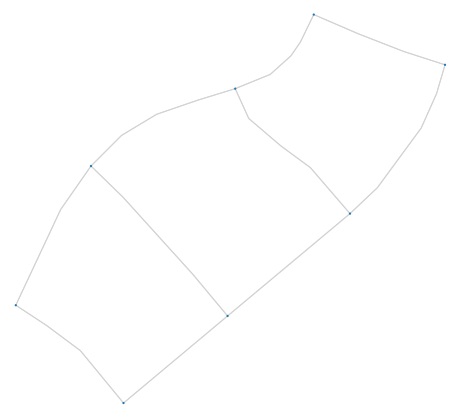

In [256]:

#Creating a bounding box
east, north, west, south = -78.810579,35.571185,-78.806234,35.574300    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
pathlist1 = list(dict.fromkeys(pathlist))
pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist1)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path(G, pathlist1)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist1:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [212]:
def node_list_to_path(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines

In [250]:
lines = node_list_to_path(G, pathlist1)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [247]:
pathlist1 = list(dict.fromkeys(pathlist))

In [248]:
pathlist1.append(pathlist1[0])

In [251]:
plot_path(lat2, long2, origin_point, destination_point)

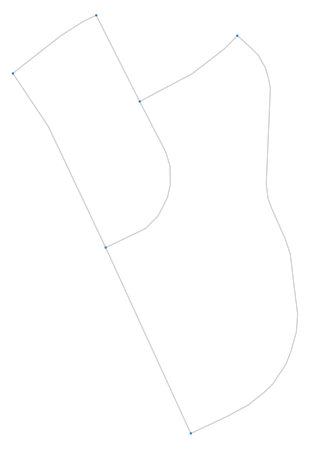

In [257]:

#Creating a bounding box
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
pathlist1 = list(dict.fromkeys(pathlist))
pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist1)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path(G, pathlist1)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist1:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)
